# Homework 2

This assignment is due Friday, February 24 at 11:59pm Central Time. 

This assignment can be completed in **groups of two**. If you need to find a partner, please post in the pinned note on Piazza.

Once you have formed your groups, the work you submit must belong only to your group members. Do not submit another team's work as your own, and do not allow another team to submit your work as their own. If you use resources you find online, you must cite those in your notebook.

To submit this assignment, you should commit to your GitHub account:

* your Net ID(s) in the netid file; one per line. Please do not put your name in your notebook; we will grade these anonymously.

* a hw2.pdf printout of the completed notebook that shows all your answers.

* your final hw2.ipynb notebook with outputs saved. If we run your notebook from scratch, it should produce an output identical to your PDF. You can edit your notebook however you want (on Colab, on your local machine, somewhere else); just upload the latest version of it to GitHub.

Your GitHub account must submit contain all three of these, or you will lose points. We will not accept late work except in extreme settings.

In [ ]:
# If using local runtime
# base_dir = "~/Documents"
# If using hosted runtime
base_dir = "/content"

# helper code from the course repository
!cd $base_dir && git clone -q https://github.com/zachwooddoughty/cs449w23.git
# install common pacakges used for deep learning
!cd $base_dir/cs449w23/ && pip install -q -r requirements.txt

# make sure we're in the right directory
%cd $base_dir/cs449w23/
!git pull -q origin main

fatal: destination path 'cs449w23' already exists and is not an empty directory.
/content/cs449w23


In [ ]:
%matplotlib inline

import datetime
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from matplotlib.animation import FuncAnimation
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm

from utils.gan import *

## GANs and Autoencoders

This homework assignment builds off the GAN notebook and the Autoencoder notebook that we saw in class. You may copy any code from those notebooks into your code.

For this assignment, you will combine the models introduced in those two notebooks to create a combined Autoencoder + GAN model. In particular, that will look something like this:

![Diagram of model architecture](https://github.com/zachwooddoughty/cs449w23/raw/main/static/hw2_fig.png)

We're giving you the defined models below and the skeleton of the training code, and you just need to define the optimizers and write the loss functions to allow these models to train together.

If we write this in a functional representation, then the encoder $E(X)$ takes in a real image and outputs a $z$ vector, $G(z)$ takes in a $z$ vecotr and outputs an image $\tilde X$, and $D(X)$ takes in an image and outputs a scalar probability.

The autoencoder loss will be MSELoss comparing $X$ and $\tilde X$ and the generator and discriminator will be otherwise the same as in a GAN. However, the tricky component is to get the model to train and reduce all three losses simultaneously.

In [ ]:
# fix random seed
torch.manual_seed(0)

class MLPGenerator(torch.nn.Module):
    
    def __init__(self, 
                 number_of_hidden_layers: int, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP generator"""
        
        super().__init__()
        
        assert number_of_hidden_layers >= 0, "Generator number_of_hidden_layers must be at least 0"
        
        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [output_size] # final output should be the size of a true example
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))
            
            if i < number_of_hidden_layers:
                layers.append(activation)
        
        # apply Sigmoid after final layer to constrain generated images to [0, 1]
        layers.append(torch.nn.Sigmoid())
        
        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor):
        return self.net(x)

class MLPDiscriminator(torch.nn.Module):
    
    def __init__(self, 
                 number_of_hidden_layers: int, 
                 input_size: int, 
                 hidden_size: int, 
                 activation: torch.nn.Module):
        """Construct a simple MLP discriminator"""
        
        super().__init__()
        
        msg = "Discriminator number_of_hidden_layers must be at least 0"
        assert number_of_hidden_layers >= 0, msg
        
        # final output dimension is scalar (probability image is real)
        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [1]
        
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))
            
            if i < number_of_hidden_layers:
                layers.append(activation)
        
        # apply sigmoid after final layer to represent probability
        layers.append(torch.nn.Sigmoid())
        
        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor):
        return self.net(x)

class MLPEncoder(torch.nn.Module):
    
    def __init__(self, 
                 number_of_hidden_layers: int, 
                 input_size: int, 
                 hidden_size: int, 
                 latent_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP encoder"""
        
        super().__init__()
        
        assert number_of_hidden_layers >= 0, "Encoder number_of_hidden_layers must be at least 0"
        
        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [latent_size]  # final output should be latent size
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))
            
            if i < number_of_hidden_layers:
                layers.append(activation)

        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor):
        return self.net(x)


class Model(torch.nn.Module):
    def __init__(self,
                 number_of_hidden_layers: int, 
                 latent_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 activation_generator: torch.nn.Module = torch.nn.ReLU(),
                 activation_discriminator: torch.nn.Module = torch.nn.LeakyReLU(0.2)
                ):
        
        super().__init__()

        self.encoder = MLPEncoder(
            number_of_hidden_layers=number_of_hidden_layers, 
            input_size=output_size, 
            hidden_size=hidden_size, 
            latent_size=latent_size,
            activation=activation_generator,
        )
                          
        self.generator = MLPGenerator(
            number_of_hidden_layers=number_of_hidden_layers, 
            input_size=latent_size, 
            hidden_size=hidden_size, 
            output_size=output_size,
            activation=activation_generator
        )
        
        self.discriminator = MLPDiscriminator(
            number_of_hidden_layers=number_of_hidden_layers, 
            input_size=output_size, 
            hidden_size=hidden_size,
            activation=activation_discriminator
        )   

In [ ]:
# training hyperparameters
image_size = 28
batch_size = 64
latent_size = 64
hidden_size = 256
number_of_hidden_layers = 2
lr = 0.0002 #NS: changing from 0.00002 to 0.0002 based on piazza post discussion.
epochs = 60

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load MNIST dataset
mnist = load_mnist(batch_size=batch_size)

# initialize the model
model = Model(
    number_of_hidden_layers=number_of_hidden_layers, 
    latent_size=latent_size, 
    hidden_size=hidden_size, 
    output_size=image_size*image_size, 
).to(device)

#NS EDIT: trying to use the optimizers from the class notebooks, one for each sub-part rather than just an optimizer for Model as a whole. can try the latter also as part of experimentation
opt_discriminator = torch.optim.Adam(model.discriminator.parameters(), lr=lr)
opt_generator = torch.optim.Adam(model.generator.parameters(), lr=lr)
opt_encoder = torch.optim.Adam(model.encoder.parameters(), lr=lr)

# discriminator loss function: binary cross-entropy loss
discrim_loss_func = torch.nn.BCELoss()
# autoencoder loss function: mean squared error between original and new image
autoencoder_loss_func = torch.nn.MSELoss()

# determine which labels will correspond to "real" and "fake" predictions from the discriminator
label_real = 1.0
label_fake = 0.0

# select a fixed set of latent vectors z that we will use to visualize the GAN's generation quality each epoch
fixed_latents = torch.randn((batch_size, latent_size)).to(device)

## Coding (7 points)

To get this code to run, you need to do two things.

* First, instantiate the optimizer(s) you will use to update your model parameters. Remember that you will need to update parameters in `model.encoder`, `model.generator`, and `model.discriminator`. One decision you have to make is how many optimizers you want to use.

* Write the training code below to compute the loss terms for each part of your model: `loss_discriminator`, `loss_generator`, and `loss_autoencoder`. As in the VAE notebook, you may want to consider weighting these losses differently.

For full points, we must be able to run your notebook as is and reproduce (almost) exactly the same results.

In [ ]:

# log metrics
loss_d = np.zeros(epochs)
loss_g = np.zeros(epochs)
loss_ae = np.zeros(epochs)

for epoch in range(epochs):
    total_epoch_size = 0

    # Zero out grads at beginning of epoch
    model.encoder.zero_grad()
    model.discriminator.zero_grad()
    model.generator.zero_grad()

    for batch_idx, batch_data in enumerate(mnist):

        x_real, y_real = batch_data
        
        # flatten input images and move to device
        x_real = x_real.to(device)
        n_batch = x_real.shape[0]
        x_real = x_real.reshape(n_batch, -1)

        # TODO: write your training code here to compute loss functions
        #   for each model section

        # NS: DISCRIMINATOR LOSS, d is trying to maximize objective log(D(x)) + log(1 - D(G(z))) #
        model.discriminator.zero_grad() 
        #train on real inputs
        y_real = torch.full((n_batch, 1), label_real, device=device)
        preds_real = model.discriminator(x_real)
        loss_real = discrim_loss_func(preds_real, y_real)
        # train on a batch of synthesized inputs
        z = torch.randn(n_batch, latent_size).to(device)
        x_fake = model.generator(z)
        y_fake = torch.full((n_batch, 1), label_fake, device=device)
        preds_fake = model.discriminator(x_fake.detach())  # exclude generator from gradient computation
        loss_fake = discrim_loss_func(preds_fake, y_fake)
        # update discriminator weights
        loss_discriminator = loss_real + loss_fake
        loss_discriminator.backward()
        opt_discriminator.step()

        # NS: GENERATOR LOSS, d is minimizing log(1 - D(G(z))) #
        model.generator.zero_grad()
        # train on a batch of synthesized inputs
        z = torch.randn(n_batch, latent_size).to(device)
        x_fake = model.generator(z)
        y_real = torch.full((n_batch, 1), label_real, device=device)
        preds_fake = model.discriminator(x_fake)
        loss_generator = discrim_loss_func(preds_fake, y_real)
        loss_generator.backward()
        # update generator weights
        opt_generator.step()

        # NS: AUTOENCODER #
        model.encoder.zero_grad()
        model.generator.zero_grad()
        z = model.encoder(x_real)
        x_fake = model.generator(z)
        loss_autoencoder = autoencoder_loss_func(x_real, x_fake) #NS: autoencoder loss is MSE of x (input to encoder) compared to x* (output of generator)
        loss_autoencoder.backward()
        opt_encoder.step()
        # update generator weights
        opt_generator.step()
        
        
        # log losses and scores
        loss_d[epoch] += loss_discriminator.detach().item() * n_batch
        loss_g[epoch] += loss_generator.detach().item() * n_batch
        loss_ae[epoch] += loss_autoencoder.detach().item() * n_batch
        total_epoch_size += n_batch

      

    loss_d[epoch] /= total_epoch_size
    loss_g[epoch] /= total_epoch_size
    loss_ae[epoch] /= total_epoch_size

    if epoch == 0 or (epoch + 1) % max(1, epochs // 10) == 0:
        total = loss_ae[epoch] + loss_g[epoch] + loss_d[epoch]
        log = "  ".join([
            f"Epoch: {epoch + 1:4d}",
            f"AE Loss: {loss_ae[epoch]:8.3f}",
            f"Gen Loss: {loss_g[epoch]:8.3f}",
            f"Dis Loss: {loss_d[epoch]:8.3f}",
            f"Total: {total:8.1f}",
        ])
        print(log)

Epoch:    1  AE Loss:    0.121  Gen Loss:    3.147  Dis Loss:    0.540  Total:      3.8
Epoch:    6  AE Loss:    0.070  Gen Loss:    6.369  Dis Loss:    0.122  Total:      6.6
Epoch:   12  AE Loss:    0.053  Gen Loss:    3.573  Dis Loss:    0.452  Total:      4.1
Epoch:   18  AE Loss:    0.037  Gen Loss:    1.669  Dis Loss:    0.873  Total:      2.6
Epoch:   24  AE Loss:    0.029  Gen Loss:    1.291  Dis Loss:    1.063  Total:      2.4
Epoch:   30  AE Loss:    0.024  Gen Loss:    1.195  Dis Loss:    1.074  Total:      2.3
Epoch:   36  AE Loss:    0.021  Gen Loss:    1.169  Dis Loss:    1.085  Total:      2.3
Epoch:   42  AE Loss:    0.019  Gen Loss:    1.192  Dis Loss:    1.061  Total:      2.3
Epoch:   48  AE Loss:    0.017  Gen Loss:    1.219  Dis Loss:    1.040  Total:      2.3
Epoch:   54  AE Loss:    0.017  Gen Loss:    1.268  Dis Loss:    1.016  Total:      2.3
Epoch:   60  AE Loss:    0.016  Gen Loss:    1.311  Dis Loss:    1.004  Total:      2.3


Once you've trained your model, use the next two cells to sample some images from your generator.

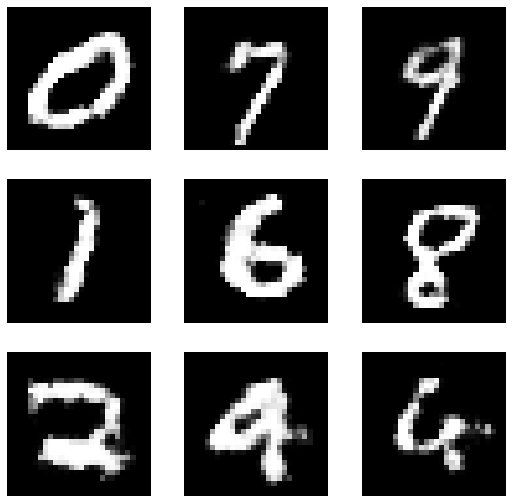

In [ ]:
nrows, ncols = (3, 3)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * nrows, 3 * ncols))

for row in range(nrows):
    for col in range(ncols):
        z = torch.randn(1, latent_size).to(device)
        output = model.generator(z).reshape(image_size, image_size).detach().cpu()
        axes[row, col].imshow(output.squeeze(), cmap='gray')
        axes[row, col].axis('off')

plt.show()

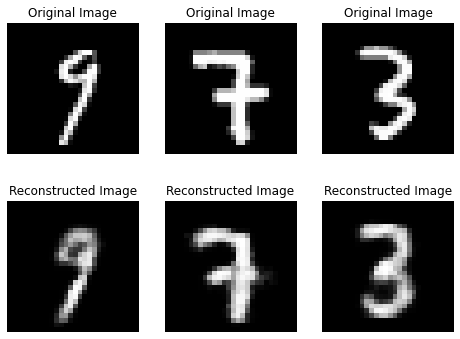

In [ ]:
example_batch = next(iter(mnist))[0].to(device)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))

indices = np.argsort(np.random.rand(example_batch.shape[0]))[:3]

for col, index in enumerate(indices):

    example_image = example_batch[index].cpu()
    axes[0, col].imshow(example_image.squeeze(), cmap='gray')
    axes[0, col].set_title("Original Image")
    axes[0, col].axis('off')

    image_input = example_image.flatten().unsqueeze(0).to(device)
    recons_img = model.generator(model.encoder(image_input))
    recons_img = recons_img.reshape(1, image_size, image_size).detach().cpu()
    axes[1, col].imshow(recons_img.squeeze(), cmap='gray')
    axes[1, col].set_title("Reconstructed Image")
    axes[1, col].axis('off')

plt.show()

## Coding explanation (6 points)

### 1. What did you do? (4 points)

Describe your approach in your code above; what choices did you make and why?

If you weren't able to get the model to train, you can still earn these points by describing what you tried and what didn't seem to work.

Dataset: We use the MNIST dataset as ground truth data for our autoencoder and as real inputs to our discriminator. We do not make any preprocessing of the data.

Hyperparameters: We have increased the learning rate originally provided by the homework because we observed that we could see better improvements on the training loss. We tried increasing the batch size to 256 and 128 but obtained worse results.

Architecture: We kept the original hidden size and number of layers.

Optimizers: We decided to use separate optimizers with the same configuration for each of the 3 components, as opposed to use only one for the whole model to prevent backpropagation from interfering with other models. This simplifies the training process as backpropagation happens in each model independently and enables us to be able to configure hyperparameters separately if needed.
In the training loop, we use the autoencoder and gan notebooks form class as reference. To train the discriminator, we use BCE loss on predicted fake or real labels from real images and images the generator produced from a random latent space. To train the generator, we use BCE loss on the label produced by the discriminator on the images that it generates from a random latent space - note that this loss is the opposite of the discriminator loss for generated images. To train the autoencoder, we use real images to produce latent representations and then use those latent representations to generate images that resemble the originals, using MSE as our loss metric (note that the generator weights are also updated during this process). 

### 2. Discuss your results (2 points)

If you were able to get your model to train, what did you notice about the trends in the three different loss values? How do your generated images in the previous cells look similar to or different from the images we saw in the GAN or Autoencoder notebooks?

We see that the autoencoder loss decreases monotonically whereas the discriminator and the generator oscillate between increasing and decreasing their respective loss. The total loss tends to decrease. The generated digits look quite similar from the digits that we produced in the other notebooks, although the reconstructions produced by our autoencoder are not as close to the original as in the autoencoder notebook. This could be because our models are optimizing for more than one task at once. 


## Conceptual questions (7 points)

### 1. Mode collapse (2 points)

Look back at the slides, notebook, and/or readings around mode collapse in GANs.
* First, give a one or two sentence definition of what mode collapse is, in your own words.
* Second, explain why mode collapse is *more* or *less* likely in the above model that incorporates an autoencoder into the GAN. Write at least two sentences.

*Mode collapse occurs when the generator produces identical (or near-identical) output regardless of input. It generally happens when the discriminator gets too powerful (is easily able to distinguish between real and fake images) so the generator resorts to only generating a small set of identical samples that can consistently fool the discriminator rather than generating diverse images (which is what we want).*

*Mode collapse is actually **less** likely to happen in a model with a GAN+encoder. The encoder, if trained well, learns latent representations in such a way that preserves the diversity of the training set (in a way that just sampling random noise, as would be the case without an enocder) would not. Thus the generator is less likely to suffer mode collapse due the representations learned by the encoder.*



### 2. Loss functions (3 points)

In the above model that you trained, there are different loss functions for the autoencoder, generator, and discriminator. For each pair of losses, describe whether and how the two losses are in conflict. That is, when training your model, does reducing loss #1 tend to increase loss #2? Why or why not?

* a. Generator loss and discriminator loss
* b. Generator loss and autoencoder loss
* c. Discriminator loss and autoencoder loss


a) The generator and the discriminator loss are in conflict - the generator decreases it's loss when it fools the discriminator, and the discriminator's loss decreases when it is not fooled. Reducing the generator's loss means producing more realistic images from hidden spaces, which means that the discriminator will be fooled more often increasing it’s loss. Similarly, as the discriminator reduces it’s loss by classifying the generator’s images as fake, the generator’s loss will increase. 


b) The generator and autoencoder loss are sometimes in conflict. Both the generator and the autoencoder loss decrease as the generator learns to generate numbers instead of noise. However, the generator may overfit on one of the tasks - for example it can learn to generate images that fool the discriminator, rotating over a few output images at the expense of not being able to reproduce the details of the original image on an autoencoding task. This is related to the concept of mode collapse in the first question. 


c) The discriminator and autoencoder loss are sometimes in conflict. These losses don’t seem to share share much commonality in the pieces of the architecture they affect. However it is possible that decreasing the autoencoder loss will lead to a higher discriminator loss as the generator component learns to produce better numbers.

### 3. Class conditioning (2 points)

Suppose you wanted to add in class-conditioning to [the generator and discriminator](https://arxiv.org/pdf/1411.1784.pdf) and [the autoencoder](https://proceedings.neurips.cc/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf) in your model. How and why would this change your loss function(s)?

*Adding class-conditioning to the generator and discriminator would not change the loss function very much: instead of log(D(x)) and log(1-D(G(z))), we would condition the input x and the latent space z on the class y, getting log(D(x|y) and log(1-D(G(z|y)).*

*For class-conditioned autoencoders (like the CVAEs in the paper), the loss function changes in a similar way. We've seen how the loss function for an AE can be represented in log terms. Instead of the log-likelihood, we are now trying to maximize the conditional log-likelihood.*
